# Testing NeuPy with Iris dataset

### Loading modules

In [1]:
%matplotlib inline
from matplotlib.pyplot import plot
import numpy as np
import random

from neupy import environment, algorithms, layers, plots
from neupy.exceptions import StopTraining

from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import theano


theano.config.floatX = 'float32'

environment.reproducible()

### Loading **iris** dataset

In [2]:
digits = np.loadtxt('exdata.csv', delimiter=',')

data = digits[:-1].T
target = digits[-1]

target[target == 10] = 0

### Normalizing the dataset

In [3]:
data_scaler = StandardScaler()
data_normalized = data_scaler.fit_transform(data)

target_scaler = OneHotEncoder()
target_normalized = target_scaler.fit_transform(target.reshape((-1, 1))).todense()

### Separating the dataset into train and test

In [4]:
data_train, data_test, target_train, target_test = train_test_split(
    data_normalized,
    target_normalized,
    train_size=(6 / 7),
)

### Creating the network

In [5]:
def check_goal(goal):
    def callback(net):
        if net.errors.last() < goal:
            raise StopTraining("Goal reached")

    return callback

net = algorithms.MinibatchGradientDescent(
    [
        layers.Input(400),
        layers.Tanh(35),
        layers.Tanh(10),
    ],
    verbose=True,
    show_epoch=1200,
#     nesterov=True,
    epoch_end_signal=check_goal(0.01),
)


Main information

[ALGORITHM] MinibatchGradientDescent

[OPTION] batch_size = 128
[OPTION] verbose = True
[OPTION] epoch_end_signal = callback
[OPTION] show_epoch = 1200
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = None

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.96 seconds


In [6]:
net.architecture()


Network's architecture

-----------------------------------------------
| # | Input shape | Layer Type | Output shape |
-----------------------------------------------
| 1 | 400         | Input      | 400          |
| 2 | 400         | Tanh       | 35           |
| 3 | 35          | Tanh       | 10           |
-----------------------------------------------



### Let's Train! :)

In [7]:
net.train(data_train, target_train, data_test, target_test, epochs=10000)


Start training

[TRAINING DATA] shapes: (4285, 400)
[TEST DATA] shapes: (715, 400)
[TRAINING] Total epochs: 10000

------------------------------------------------
| Epoch # | Train err | Valid err | Time       |
------------------------------------------------
| 1       | 0.3125    | 0.216     | 34 ms      |
| 1200    | 0.01755   | 0.03336   | 25 ms      |
| 2400    | 0.01478   | 0.03457   | 25 ms      |
| 3600    | 0.01355   | 0.03565   | 25 ms      |
| 4800    | 0.01281   | 0.0368    | 34 ms      |
| 6000    | 0.01225   | 0.03763   | 26 ms      |
| 7200    | 0.01183   | 0.03854   | 28 ms      |
| 8400    | 0.01151   | 0.03924   | 25 ms      |
| 9600    | 0.01126   | 0.03976   | 0.1 sec    |
| 10000   | 0.01119   | 0.03991   | 26 ms      |
------------------------------------------------



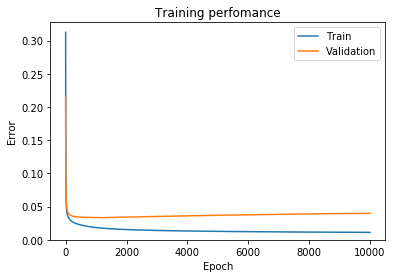

In [8]:
plots.error_plot(net)

### Now we can test the network

#### First on the whole dataset

In [9]:
predicted = net.predict(data_normalized)
predicted_classes = np.asarray(predicted.argmax(axis=1)).reshape(-1)

In [10]:
metrics.confusion_matrix(target, predicted_classes)

array([[494,   0,   0,   1,   1,   0,   2,   0,   2,   0],
       [  1, 496,   1,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 486,   4,   0,   0,   5,   2,   3,   0],
       [  0,   1,   0, 490,   1,   3,   0,   4,   1,   0],
       [  1,   1,   3,   0, 492,   0,   2,   0,   0,   1],
       [  1,   1,   1,   2,   2, 488,   1,   0,   3,   1],
       [  3,   2,   0,   0,   2,   5, 487,   0,   1,   0],
       [  1,   5,   1,   0,   1,   0,   0, 490,   0,   2],
       [  0,   3,   0,   1,   3,   4,   2,   0, 485,   2],
       [  2,   1,   1,   4,   2,   1,   0,   4,   3, 482]])

In [11]:
print(metrics.classification_report(target, predicted_classes))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99       500
        1.0       0.97      0.99      0.98       500
        2.0       0.99      0.97      0.98       500
        3.0       0.98      0.98      0.98       500
        4.0       0.98      0.98      0.98       500
        5.0       0.97      0.98      0.98       500
        6.0       0.97      0.97      0.97       500
        7.0       0.98      0.98      0.98       500
        8.0       0.97      0.97      0.97       500
        9.0       0.99      0.96      0.98       500

avg / total       0.98      0.98      0.98      5000



### Then only on the test set

In [12]:
predicted_test = net.predict(data_test)
predicted_test_classes = np.asarray(predicted_test.argmax(axis=1)).reshape(-1)
target_test_classes = np.asarray(target_test.argmax(axis=1)).reshape(-1)

In [13]:
metrics.confusion_matrix(target_test_classes, predicted_test_classes)

array([[75,  0,  0,  1,  0,  0,  0,  0,  1,  0],
       [ 1, 68,  0,  0,  0,  0,  1,  0,  1,  0],
       [ 0,  0, 55,  4,  0,  0,  3,  2,  3,  0],
       [ 0,  0,  0, 58,  0,  3,  0,  1,  0,  0],
       [ 1,  1,  3,  0, 52,  0,  2,  0,  0,  1],
       [ 1,  1,  1,  1,  1, 73,  0,  0,  3,  1],
       [ 0,  0,  0,  0,  2,  4, 58,  0,  1,  0],
       [ 1,  2,  0,  0,  0,  0,  0, 77,  0,  2],
       [ 0,  2,  0,  1,  3,  4,  1,  0, 66,  2],
       [ 1,  1,  1,  1,  2,  1,  0,  4,  1, 58]])

In [14]:
print(metrics.classification_report(target_test_classes, predicted_test_classes))

             precision    recall  f1-score   support

          0       0.94      0.97      0.96        77
          1       0.91      0.96      0.93        71
          2       0.92      0.82      0.87        67
          3       0.88      0.94      0.91        62
          4       0.87      0.87      0.87        60
          5       0.86      0.89      0.87        82
          6       0.89      0.89      0.89        65
          7       0.92      0.94      0.93        82
          8       0.87      0.84      0.85        79
          9       0.91      0.83      0.87        70

avg / total       0.90      0.90      0.89       715



In [15]:
print("Dataset accuracy: {:.2%}".format(metrics.accuracy_score(target, predicted_classes)))
print("Test set accuracy: {:.2%}".format(metrics.accuracy_score(target_test_classes, predicted_test_classes)))

Dataset accuracy: 97.80%
Test set accuracy: 89.51%
